# Formula for voltage accross capacitor
$$
\frac{V}{V_0} = \frac{X_C}{R+X_C} = \frac{i}{\omega C}\frac{1}{R +i/\omega C}
$$

Simplifying gives

$$
\frac{V}{V_0} = \frac{1}{iR\omega C +  1}
$$



In [100]:
# April 15 2025
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as scc

In [101]:
# Parameters for time domain simulation
N = 2**20                             # Number of time steps (high resolution for clean FFT)
T = 100 * scc.milli                   # Total duration of simulation [s]
dt = T / N                            # Time step [s]
print(f'Time step dt = {dt/scc.nano:5.2f} ns')

t = np.linspace(0, T, N, endpoint=False)  # Time array from 0 to T (exclusive)

# Construct input signal: a rectangular pulse from 1/3*T to 2/3*T
u_t = np.zeros(N)
u_t[N//3 : 2*N//3] = 1                # Set pulse amplitude to 1 over the middle third of the interval

# Fourier transform of the input signal (scaled by dt)
U_w = np.fft.fft(u_t) * dt

# Frequency axis for FFT, with epsilon added to avoid divide-by-zero
w = 2 * np.pi * np.fft.fftfreq(N, d=dt) + np.finfo(float).eps  # Angular frequency [rad/s]

# RC circuit parameters
R = 1 * scc.mega                     # Resistance [Ohms]
C = 40 * scc.pico                    # Capacitance [Farads]

# RC circuit transfer function: H(w) = 1 / (1 + iωRC)
H_w = 1 / (1 + 1j * w * R * C)

# Multiply input spectrum by transfer function in frequency domain
V_w = H_w * U_w

# Inverse Fourier transform to get output voltage in time domain
v_t = np.fft.ifft(V_w).real / dt     # Normalize result by 1/dt to reverse FFT scaling

# Set t0 for plotting or signal alignment (here aligned with end of pulse)
t0 = 2 * T / 3


Time step dt = 95.37 ns


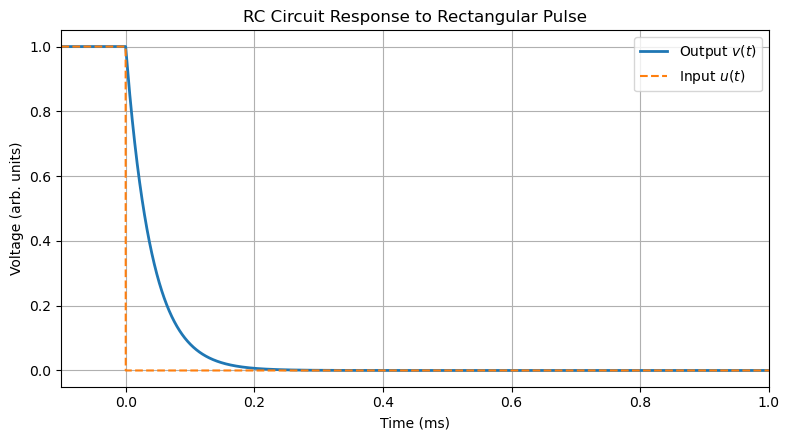

In [102]:
# Plot time-domain response of the RC circuit to a rectangular pulse
plt.figure(figsize=(8, 4.5))

# Shift time axis so pulse is centered around t = 0
plt.plot((t - t0) / scc.milli, v_t, label="Output $v(t)$", linewidth=2)
plt.plot((t - t0) / scc.milli, u_t, '--', label="Input $u(t)$", linewidth=1.5)

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (arb. units)")
plt.title("RC Circuit Response to Rectangular Pulse")

plt.xlim(-0.1, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [103]:
# Test: Recover frequency-domain response from the real part of the time-domain output

# Goal:
# Verify whether using only Re[v(t)] (i.e., the real-valued time-domain signal)
# allows recovery of the full complex frequency response H(w).
# According to the Kramers-Kronig relations, this should be possible in principle.

# Compute FFT of real-valued time-domain output
V_w_recover = np.fft.fft(np.real(v_t)) * dt   # Simulate having access to only Re[v(t)]

# Reconstruct transfer function: H(w) = V(w) / U(w)
H_w_recovered = V_w_recover / U_w

# Sort frequency axis for cleaner plotting and comparison
sort_idx = np.argsort(w)
w_sorted = w[sort_idx]
H_w_sorted = H_w_recovered[sort_idx]
H_w_true_sorted = H_w[sort_idx]  # True transfer function (from earlier cell), for reference




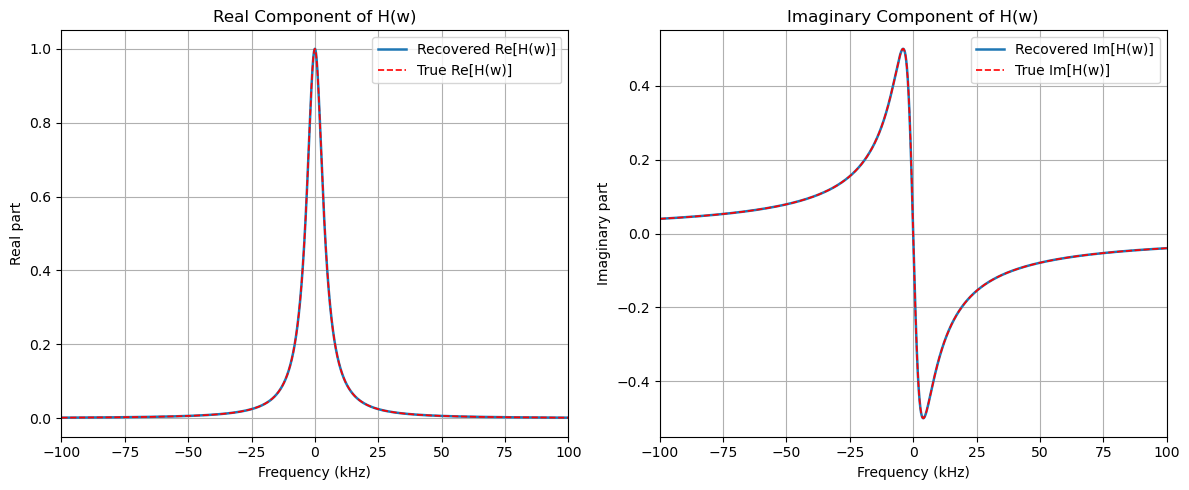

w shape: (1048576,) t shape: (1048576,)


In [104]:
# Plot comparison of recovered vs. true transfer function components (real and imaginary parts)
plt.figure(figsize=(12, 5))

# Plot real part of H(w)
plt.subplot(1, 2, 1)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.real(H_w_sorted), label="Recovered Re[H(w)]", linewidth=1.8)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.real(H_w_true_sorted), '--r', label="True Re[H(w)]", linewidth=1.2)
plt.xlim(-100, 100)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Real part")
plt.title("Real Component of H(w)")
plt.grid(True)
plt.legend()

# Plot imaginary part of H(w)
plt.subplot(1, 2, 2)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.imag(H_w_sorted), label="Recovered Im[H(w)]", linewidth=1.8)
plt.plot(w_sorted / (2 * np.pi * 1e3), np.imag(H_w_true_sorted), '--r', label="True Im[H(w)]", linewidth=1.2)
plt.xlim(-100, 100)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Imaginary part")
plt.title("Imaginary Component of H(w)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Debug: confirm array shapes
print("w shape:", np.shape(w), "t shape:", np.shape(t))



In [105]:
# === Define frequency-dependent dielectric constant for a sugar solution ===
# This combines:
#   - Debye relaxation: frequency-dependent polarization
#   - Conductive loss: modeled as an imaginary term from bulk resistivity

# Experimental resistivity (ρ) of water vs temperature [°C]
Temps = np.array([0, 10, 20, 30, 40, 50])                  # Temperature in °C
rho = np.array([85.841, 43.297, 23.844, 14.082, 8.810, 5.791]) * 1e4  # Resistivity in ohm·cm → convert to ohm·m

# Fit ln(rho) as a function of temperature for smooth interpolation
a, b, c = np.polyfit(Temps, np.log(rho), 2)

# Interpolating function for resistivity of water (approximation for sugar solution)
def rho_W(T_Kelvin):
    """Returns resistivity [ohm·m] at given temperature [K]."""
    T_Celsius = T_Kelvin - 273.15
    return np.exp(a * T_Celsius**2 + b * T_Celsius + c) * scc.centi  # convert cm → m

# Frequency-dependent dielectric constant including conductivity and Debye relaxation
def eps_sugar(omega, T_Kelvin, tau):
    """
    Returns complex dielectric constant for a sugar solution.
    omega: angular frequency array [rad/s]
    T_Kelvin: temperature [K]
    tau: relaxation time [s]
    """
    Delta_k = 100   # Relaxation strength (Δκ = ε_static - ε_infinity), assumed constant
    sigma = 1 / rho_W(T_Kelvin)  # Conductivity [S/m]
    
    # ε*(ω) = 1 + Δκ / (1 + iωτ) - iσ / (ε₀ω)
    eps = 1 + Delta_k / (1 + 1j * omega * tau) - 1j * sigma / (scc.epsilon_0 * omega)
    return eps

# === Set temperature and relaxation time parameters ===
tau = 1e-5                  # Debye relaxation time [s]
Temperature = 220           # Temperature [K]

# Use subrange of frequency array w, corresponding to 10 Hz – 1 MHz
f = w / (2 * np.pi)
freq_mask = (f > 10) & (f < 1e6)
w_sub = w[freq_mask]

# Evaluate dielectric function on selected frequency range
eps = eps_sugar(w_sub, Temperature, tau)


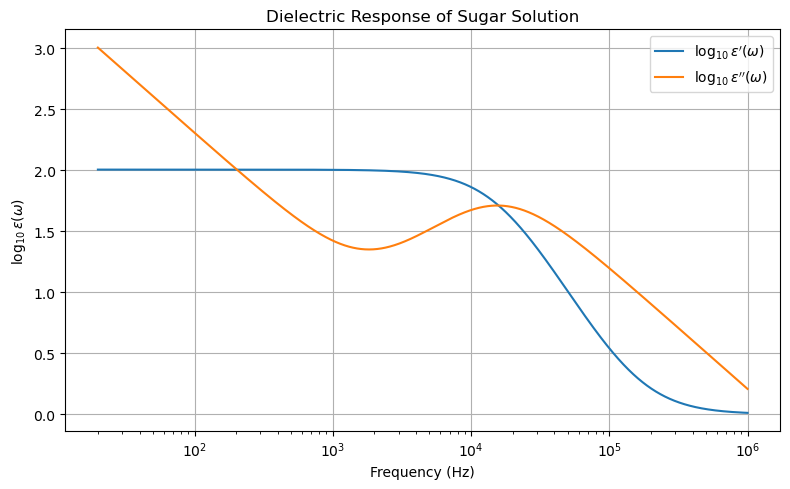

In [106]:
# Plot the real and imaginary parts of the dielectric function on a log-frequency axis
f_sub = w_sub / (2 * np.pi)  # Convert angular frequency [rad/s] to Hz

plt.figure(figsize=(8, 5))

# Plot log10 of real and imaginary parts
plt.plot(f_sub, np.log10(np.real(eps)), label=r"$\log_{10} \epsilon'(\omega)$")
plt.plot(f_sub, np.log10(-np.imag(eps)), label=r"$\log_{10} \epsilon''(\omega)$")

plt.xscale("log")
plt.yscale("linear")
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\log_{10} \epsilon(\omega)$')
plt.grid(True)
plt.legend()
plt.title("Dielectric Response of Sugar Solution")
plt.tight_layout()
plt.show()


In [107]:

# Compute frequency-dependent dielectric function across full frequency range
eps_full = eps_sugar(w, Temperature, tau)

# Update transfer function: H(w) = 1 / [1 + iωRCε(ω)]
H_w = 1 / (1 + 1j * w * R * C * eps_full)

# Multiply by Fourier-transformed input signal
V_w = H_w * U_w

# Inverse FFT to get time-domain output voltage
v_t = np.fft.ifft(V_w).real / dt  # Rescale to undo FFT scaling



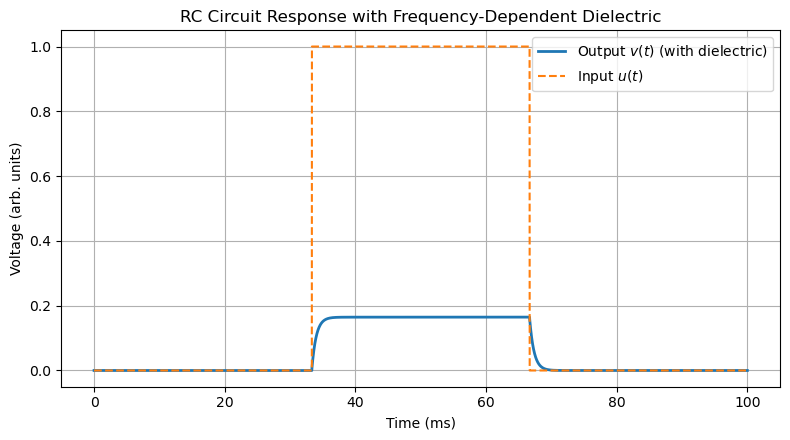

In [108]:
plt.figure(figsize=(8, 4.5))

plt.plot(t / scc.milli, v_t, label="Output $v(t)$ (with dielectric)", linewidth=2)
plt.plot(t / scc.milli, u_t, '--', label="Input $u(t)$", linewidth=1.5)

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (arb. units)")
plt.title("RC Circuit Response with Frequency-Dependent Dielectric")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [109]:
# === Recover frequency-domain response from real-valued output ===

# Take FFT of the real part of the time-domain output (as if only Re[v(t)] were measurable)
V_w_recover = np.fft.fft(np.real(v_t)) * dt

# Recover the system transfer function H(ω) from output/input in frequency domain
H_w_recovered = V_w_recover / U_w

# Sort frequencies and corresponding transfer function values for clean plotting
sort_idx = np.argsort(w)
w_sorted = w[sort_idx]
H_w_sorted = H_w_recovered[sort_idx]
H_w_true_sorted = H_w[sort_idx]  # Theoretical transfer function with dielectric, for comparison





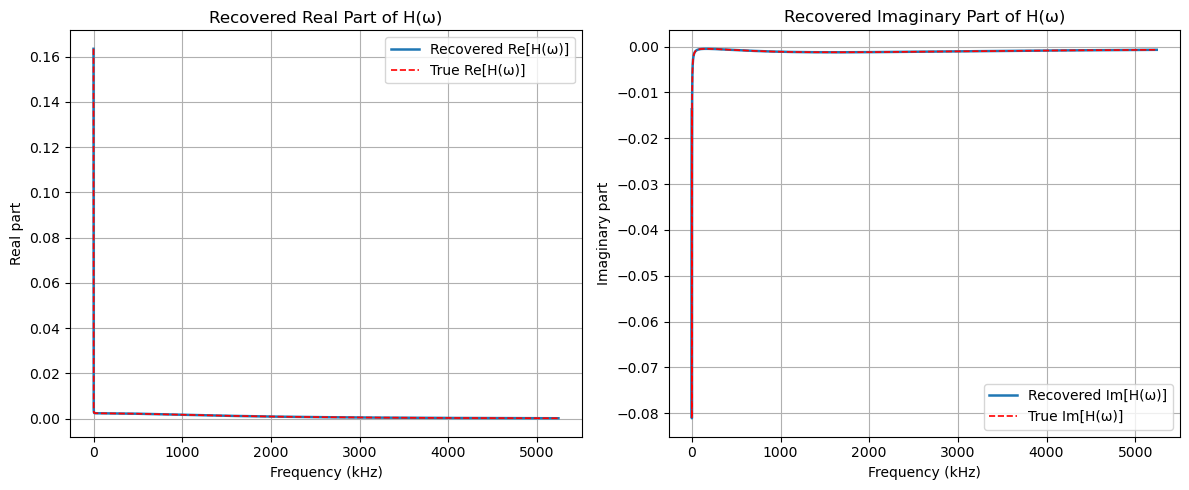

In [110]:
# Mask for positive frequencies above 10 Hz
f_sorted = w_sorted / (2 * np.pi)  # frequency in Hz
plot_mask = (f_sorted > 10)

freq_kHz = f_sorted[plot_mask] / 1e3  # convert to kHz for x-axis

# Plot comparison of real and imaginary parts of H(w)
plt.figure(figsize=(12, 5))

# Real part
plt.subplot(1, 2, 1)
plt.plot(freq_kHz, np.real(H_w_sorted[plot_mask]), label="Recovered Re[H(ω)]", linewidth=1.8)
plt.plot(freq_kHz, np.real(H_w_true_sorted[plot_mask]), '--r', label="True Re[H(ω)]", linewidth=1.2)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Real part")
plt.title("Recovered Real Part of H(ω)")
plt.grid(True)
plt.legend()

# Imaginary part
plt.subplot(1, 2, 2)
plt.plot(freq_kHz, np.imag(H_w_sorted[plot_mask]), label="Recovered Im[H(ω)]", linewidth=1.8)
plt.plot(freq_kHz, np.imag(H_w_true_sorted[plot_mask]), '--r', label="True Im[H(ω)]", linewidth=1.2)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Imaginary part")
plt.title("Recovered Imaginary Part of H(ω)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



# Now solve for epsilon 

Since 


$$
H = \frac{1}{iR\omega C_0 \epsilon(\omega)+  1}
$$

$$
\epsilon(\omega)  i R \omega C_0 + 1 = \frac{1}{H}
$$

$$
\epsilon(\omega) = \left(\frac{1}{H}-1\right)\left(\frac{1}{ i R \omega C_0}\right)
$$


In [111]:
epsilon_recovered = (1/H_w_sorted -1)*(1/(1j*R*w_sorted*C))




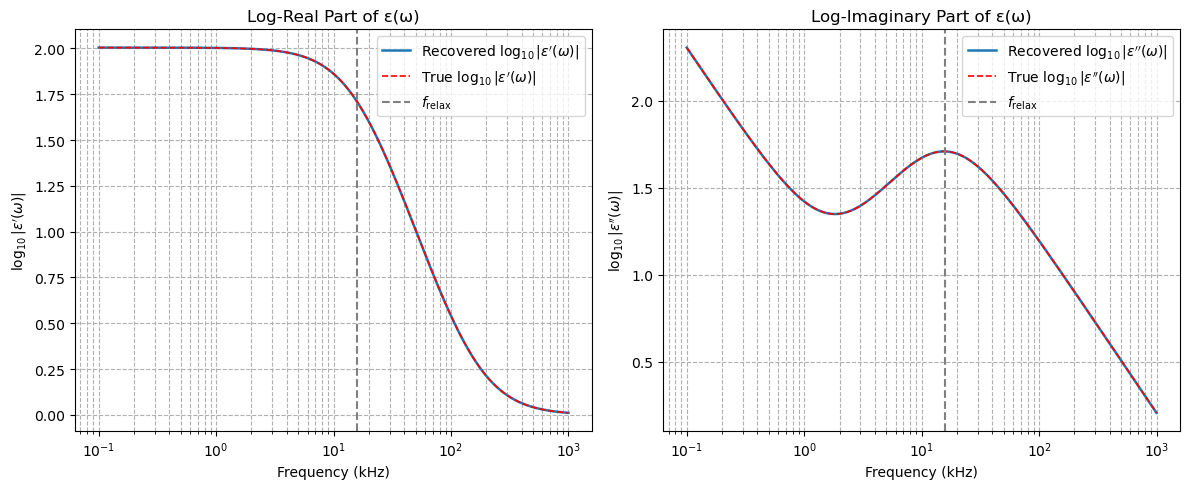

In [115]:
# Define frequency mask: only include 100 Hz to 1 MHz
f_sorted = w_sorted / (2 * np.pi)  # frequency in Hz
plot_mask = (f_sorted >= 100) & (f_sorted <= 1e6)

freq_kHz = f_sorted[plot_mask] / 1e3  # convert to kHz for plotting

# Extract recovered components
eps_rec = epsilon_recovered[plot_mask]
eps_rec_real = np.real(eps_rec)
eps_rec_imag = np.abs(np.imag(eps_rec))  # abs for safe log

# Compute true epsilon over same frequency range
eps_true_full = eps_sugar(w_sorted, Temperature, tau)
eps_true = eps_true_full[plot_mask]
eps_true_real = np.real(eps_true)
eps_true_imag = np.abs(np.imag(eps_true))

# Use machine epsilon to avoid log(0)
eps_machine = np.finfo(float).eps
eps_rec_real_log = np.log10(np.abs(eps_rec_real) + eps_machine)
eps_rec_imag_log = np.log10(eps_rec_imag + eps_machine)
eps_true_real_log = np.log10(np.abs(eps_true_real) + eps_machine)
eps_true_imag_log = np.log10(eps_true_imag + eps_machine)

# Calculate relaxation frequency (in kHz)
f_relax_kHz = 1 / (2 * np.pi * tau) / 1e3

# Plot log₁₀ of real and imaginary parts of epsilon with log-x
plt.figure(figsize=(12, 5))

# Real part
plt.subplot(1, 2, 1)
plt.plot(freq_kHz, eps_rec_real_log, label=r"Recovered $\log_{10}|\epsilon'(\omega)|$", linewidth=1.8)
plt.plot(freq_kHz, eps_true_real_log, '--r', label=r"True $\log_{10}|\epsilon'(\omega)|$", linewidth=1.2)
plt.axvline(f_relax_kHz, color='gray', linestyle='--', label=r"$f_{\mathrm{relax}}$")
plt.xscale("log")
plt.xlabel("Frequency (kHz)")
plt.ylabel(r"$\log_{10} |\epsilon'(\omega)|$")
plt.title("Log-Real Part of ε(ω)")
plt.grid(True, which="both", ls="--")
plt.legend()

# Imaginary part
plt.subplot(1, 2, 2)
plt.plot(freq_kHz, eps_rec_imag_log, label=r"Recovered $\log_{10}|\epsilon''(\omega)|$", linewidth=1.8)
plt.plot(freq_kHz, eps_true_imag_log, '--r', label=r"True $\log_{10}|\epsilon''(\omega)|$", linewidth=1.2)
plt.axvline(f_relax_kHz, color='gray', linestyle='--', label=r"$f_{\mathrm{relax}}$")
plt.xscale("log")
plt.xlabel("Frequency (kHz)")
plt.ylabel(r"$\log_{10} |\epsilon''(\omega)|$")
plt.title("Log-Imaginary Part of ε(ω)")
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()
plt.show()
